In [2]:
!pip install torch torchvision pandas tqdm requests scikit-learn


In [7]:
import os
import requests
from tqdm import tqdm
import zipfile
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ตั้งค่า URL และที่เก็บไฟล์
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
output_dir = 'har_dataset'
zip_filename = os.path.join(output_dir, 'UCI_HAR_Dataset.zip')

# สร้างไดเรกทอรีหากไม่มี
os.makedirs(output_dir, exist_ok=True)

# ดาวน์โหลดไฟล์พร้อมแสดงแถบความคืบหน้า
response = requests.get(url, stream=True)
total_size_in_bytes = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 Kibibyte
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

with open(zip_filename, 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
progress_bar.close()

# ตรวจสอบว่าดาวน์โหลดไฟล์ครบถ้วนหรือไม่
if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    raise Exception("ERROR, something went wrong with the download")

# แตกไฟล์ zip ที่โหลดมา
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# ลบไฟล์ zip หลังจากแตกไฟล์แล้ว
os.remove(zip_filename)

# ฟังก์ชันสำหรับโหลดข้อมูล
def load_data(base_path):
    features = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'features.txt'), delim_whitespace=True, header=None)
    activity_labels = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'activity_labels.txt'), delim_whitespace=True, header=None)
    
    # โหลดชุดข้อมูลการฝึกอบรม
    X_train = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'train', 'X_train.txt'), delim_whitespace=True, header=None)
    y_train = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'train', 'y_train.txt'), delim_whitespace=True, header=None)
    
    # โหลดชุดข้อมูลการทดสอบ
    X_test = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'test', 'X_test.txt'), delim_whitespace=True, header=None)
    y_test = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'test', 'y_test.txt'), delim_whitespace=True, header=None)

    return X_train, y_train, X_test, y_test, features, activity_labels

base_path = output_dir
X_train, y_train, X_test, y_test, features, activity_labels = load_data(base_path)

# การทำ normalization ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# การแปลง label เป็นตัวเลข
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.values.ravel())
y_test = encoder.transform(y_test.values.ravel())

# สร้าง Custom Dataset
class HAR_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HAR_Dataset(X_train, y_train)
test_dataset = HAR_Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


61.0MiB [00:09, 6.44MiB/s]
/tmp/ipykernel_247503/2555118125.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'features.txt'), delim_whitespace=True, header=None)
/tmp/ipykernel_247503/2555118125.py:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'activity_labels.txt'), delim_whitespace=True, header=None)
/tmp/ipykernel_247503/2555118125.py:49: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(os.path.join(base_path, 'UCI HAR Dataset', 'train', 'X_train.txt'), delim_whitespace=True, header=None)
/tmp/ipykernel_247503/2555118125.py:50: Fut

Optimizer: SGD
Epoch [1/20], Loss: 1.7416
Epoch [2/20], Loss: 1.6180
Epoch [3/20], Loss: 1.4645
Epoch [4/20], Loss: 1.2906
Epoch [5/20], Loss: 1.1283
Epoch [6/20], Loss: 0.9906
Epoch [7/20], Loss: 0.8738
Epoch [8/20], Loss: 0.7721
Epoch [9/20], Loss: 0.6830
Epoch [10/20], Loss: 0.6078
Epoch [11/20], Loss: 0.5462
Epoch [12/20], Loss: 0.4963
Epoch [13/20], Loss: 0.4557
Epoch [14/20], Loss: 0.4217
Epoch [15/20], Loss: 0.3931
Epoch [16/20], Loss: 0.3681
Epoch [17/20], Loss: 0.3464
Epoch [18/20], Loss: 0.3271
Epoch [19/20], Loss: 0.3098
Epoch [20/20], Loss: 0.2941
Accuracy of the model on the test set: 90.50%
F1 Score of the model on the test set: 0.9042
--------------------------------------------------
Optimizer: Adam
Epoch [1/20], Loss: 0.2898
Epoch [2/20], Loss: 0.0940
Epoch [3/20], Loss: 0.0723
Epoch [4/20], Loss: 0.0506
Epoch [5/20], Loss: 0.0523
Epoch [6/20], Loss: 0.0501
Epoch [7/20], Loss: 0.0346
Epoch [8/20], Loss: 0.0298
Epoch [9/20], Loss: 0.0268
Epoch [10/20], Loss: 0.0282
Epoc

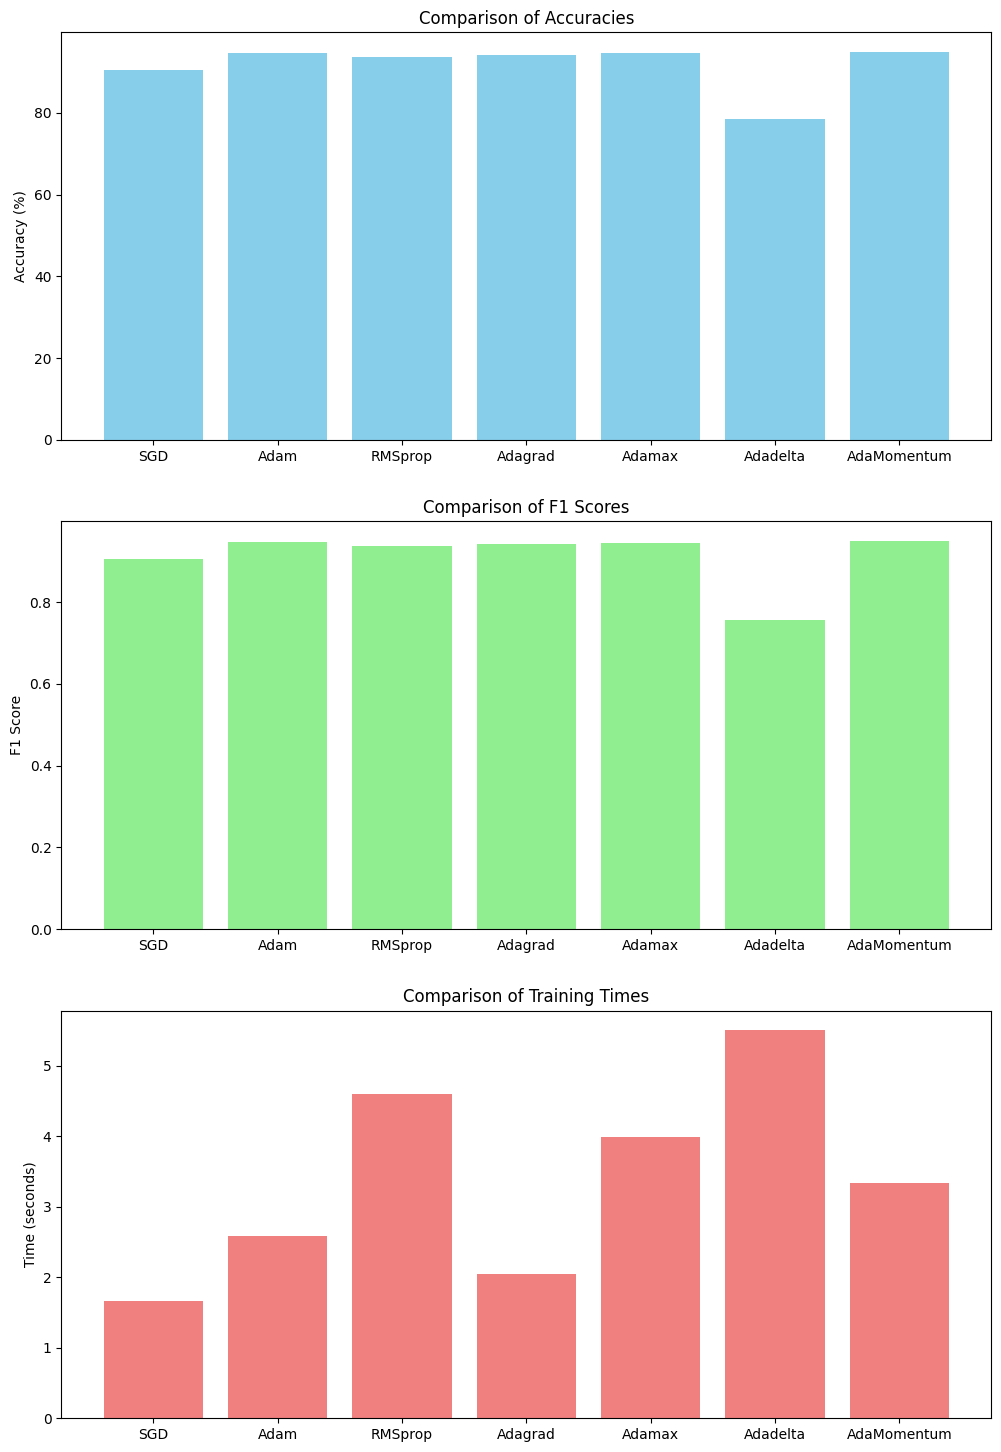

Summary of results:

Optimizer: SGD
Accuracy: 90.50%
F1 Score: 0.9042
Training Time: 1.66 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       496
           1       0.92      0.96      0.94       471
           2       0.96      0.84      0.90       420
           3       0.86      0.75      0.80       491
           4       0.80      0.92      0.86       532
           5       1.00      0.97      0.98       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947


Optimizer: Adam
Accuracy: 94.71%
F1 Score: 0.9472
Training Time: 2.59 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       496
           1       0.93      0.96      0.95       471
           2       0.98      0.92      0.95       420
           3     

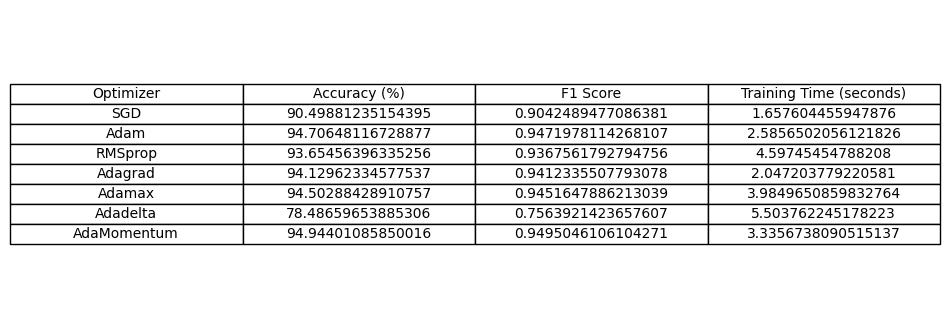

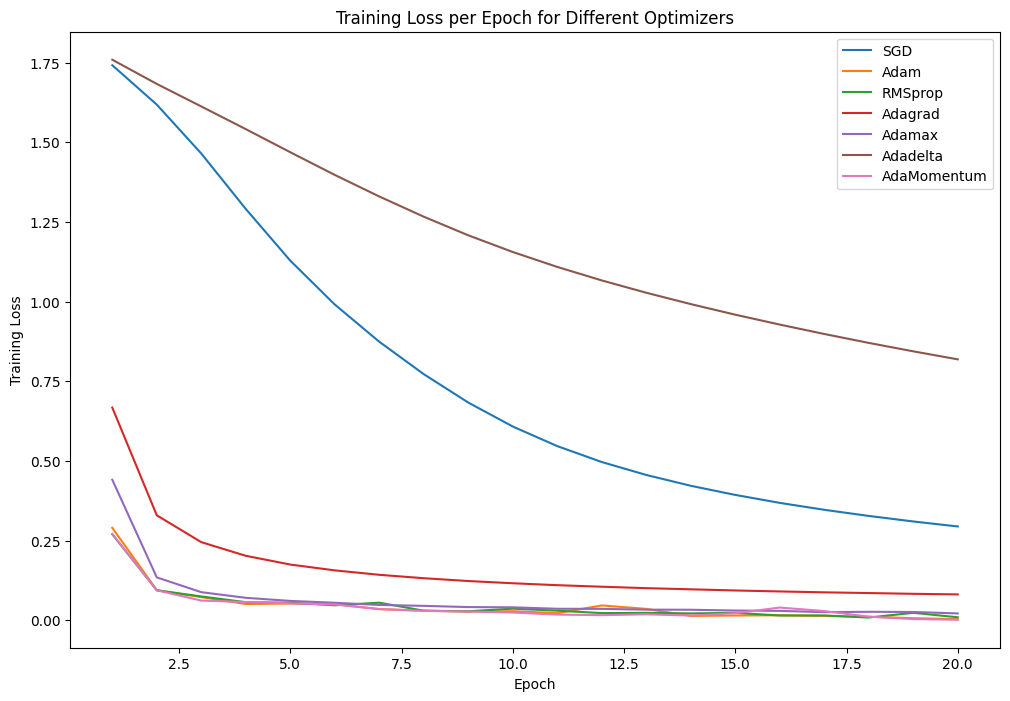

In [22]:
import time
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# AdaMomentum optimizer class
class AdaMomentum(optim.Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdaMomentum, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['v_hat_prev'] = torch.zeros_like(p.data)

                m, v = state['m'], state['v']
                state['step'] += 1
                step = state['step']

                # Update m and v using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                v_hat = v / (1 - beta2 ** step)

                # Dynamic learning rate adjustment
                if step == 1:
                    eta_t = lr
                else:
                    eta_t = lr * (torch.sqrt((v_hat / (state['v_hat_prev'] + eps)).mean()).clamp(max=10))

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(v_hat) + eps, value=-eta_t)
                state['v_hat_prev'].copy_(v_hat)

        return loss

class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    start_time = time.time()
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    elapsed_time = time.time() - start_time
    return model, train_losses, elapsed_time

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaMomentum': AdaMomentum
}

results = {}

for name, optim_func in optimizers.items():
    print(f'Optimizer: {name}')
    model = HAR_Model(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim_func(model.parameters(), lr=0.001)
    trained_model, train_losses, training_time = train_model(model, train_loader, criterion, optimizer)
    accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'train_losses': train_losses,
        'training_time': training_time,
        'classification_report': class_report
    }
    print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]
training_times = [results[name]['training_time'] for name in optim_names]

# กราฟแสดงผล Accuracy, F1-score และ Training Time
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].bar(optim_names, accuracies, color='skyblue')
axs[0].set_title('Comparison of Accuracies')
axs[0].set_ylabel('Accuracy (%)')

axs[1].bar(optim_names, f1_scores, color='lightgreen')
axs[1].set_title('Comparison of F1 Scores')
axs[1].set_ylabel('F1 Score')

axs[2].bar(optim_names, training_times, color='lightcoral')
axs[2].set_title('Comparison of Training Times')
axs[2].set_ylabel('Time (seconds)')

plt.show()

# พิมพ์รายงานสรุป
print('Summary of results:')
for optim_name, metrics in results.items():
    print(f'\nOptimizer: {optim_name}')
    print(f"Accuracy: {metrics['accuracy']:.2f}%")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Training Time: {metrics['training_time']:.2f} seconds")
    print(f"Classification Report:\n{metrics['classification_report']}")



# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]
training_times = [results[name]['training_time'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores,
    'Training Time (seconds)': training_times
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()